In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torchqc.states import QuantumState
from torchqc.common_functions import get_density_matrix, expect_val, fidelity
from torchqc.operators import DynamicOperator
from torchqc.common_matrices import annihilation, creation, eye, sigmaMinus, sigmaPlus
from torchqc.dynamics import TDSE
from torchqc.tensor_product import tensor_product_ops, tensor_product_states, partial_trace

torch.manual_seed(12674434747310128456)

* Define Neural Network

In [41]:
Ωo = 1
max_control = 1.

class NeuralNet(nn.Module):
    def __init__(self, hidden_size, nb_hidden_layers = 2, input_size = 1, output_size = 1, activation_fn = nn.Tanh):
        super(NeuralNet, self).__init__()

        self.nb_hidden_layers = nb_hidden_layers
        self.hidden_layers = []
        self.hidden_act_layers = []

        # input layer
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.relu_input = activation_fn()

        # hidden layers
        for layer in range(nb_hidden_layers):
            new_layer = nn.Linear(hidden_size, hidden_size)
            self.hidden_layers.append(new_layer)
            self.hidden_act_layers.append(activation_fn())
            
            # hidden layer parameters should be registered
            self.register_parameter(f"weights_{layer}", new_layer.weight)
            self.register_parameter(f"bias_{layer}", new_layer.bias)

        # output layer
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.input_layer(x)
        out = self.relu_input(out)

        for layer in range(self.nb_hidden_layers):
            out = self.hidden_layers[layer](out)
            out = self.hidden_act_layers[layer](out)

        out = self.output_layer(out)
        out = torch.clip(input=out, min=-max_control, max=max_control)

        return out

In [42]:
class Sin(nn.Module):
    """The sin activation function.
    """

    def __init__(self):
        """Initializer method.
        """
        super().__init__()

    def forward(self, input_):
        return torch.sin(input_)

* Start from basis state $\ket{0}$

In [43]:
N = 6 # resonator modes
n = 2
# tensor product of two qubits and a resonator mode
total_dims = n * n * n * N

qubit_states_basis = QuantumState.basis(n)
resonator_basis_states = QuantumState.basis(N)

qubit1_state = qubit_states_basis[0]
qubit2_state = qubit_states_basis[1]
qubit3_state = qubit_states_basis[0]
resonator_state = resonator_basis_states[0]

initial_state = tensor_product_states(qubit1_state, qubit2_state, qubit3_state, resonator_state)
target_state = (1 / np.sqrt(2)) * (tensor_product_states(qubit_states_basis[0], qubit_states_basis[0], qubit_states_basis[0]) + tensor_product_states(qubit_states_basis[1], qubit_states_basis[1], qubit_states_basis[1]))
target_state = get_density_matrix(target_state)

* Simulate dynamics with TDSE

In [44]:
T = 8
Dt = 0.1
time = np.arange(0, T, Dt, dtype = np.float32)
time_tensor = torch.from_numpy(time).reshape(len(time), 1)

In [ ]:
BBNN = NeuralNet(hidden_size=25, input_size=1, output_size=4, nb_hidden_layers=8, activation_fn=nn.Tanh)

* Construct Hamiltonian and define loss function

$H = \sum_{j=1}^3 g_j(t) (a^\dagger \sigma^-_j + a \sigma^+_j) + \xi(t) (a + a^\dagger) $

In [46]:
a_dagger = creation(N)
a = annihilation(N)
sm = sigmaMinus()
sp = sigmaPlus()

def quantum_simulation(u_pred):
    g1 = u_pred[:, 0:1]
    g1.unsqueeze_(-1)
    g1.expand(len(time), total_dims, total_dims)

    g2 = u_pred[:, 1:2]
    g2.unsqueeze_(-1)
    g2.expand(len(time), total_dims, total_dims)

    g3 = u_pred[:, 2:3]
    g3.unsqueeze_(-1)
    g3.expand(len(time), total_dims, total_dims)

    ξ = u_pred[:, 3:4]
    ξ.unsqueeze_(-1)
    ξ.expand(len(time), total_dims, total_dims)

    H1 = g1 * (tensor_product_ops(sm, eye(n), eye(n), a_dagger) + tensor_product_ops(sp, eye(n), eye(n), a)) \
    + g2 * (tensor_product_ops(eye(n), sm, eye(n), a_dagger) + tensor_product_ops(eye(n), sp, eye(n), a)) \
        + g3 * (tensor_product_ops(eye(n), eye(n), sm, a_dagger) + tensor_product_ops(eye(n), eye(n), sp, a))

    H2 = ξ * tensor_product_ops(eye(n), eye(n), eye(n), a_dagger + a)

    H = H1 + H2

    hamiltonian = DynamicOperator(total_dims, H.matrix)
    states = TDSE(initial_state, hamiltonian, time, Dt)

    return states

def criterion_fidelity_custom(u_pred):
    states = quantum_simulation(u_pred)

    population_of_highest_mode_sum = torch.sum(Dt * torch.stack([torch.real(expect_val(QuantumState.basis(N)[-1], partial_trace(get_density_matrix(state), [0, 1, 2]))) for state in states]))

    phi1 = (0.1 / T) * population_of_highest_mode_sum
    
    achieved_state = get_density_matrix(states[-1])
    reduced_achieved_state = partial_trace(achieved_state, [3])

    infidelity = 1 - fidelity(reduced_achieved_state, target_state)

    return infidelity + phi1

* Training loop of the Deep NN using the defined objective function

In [47]:
def training(learning_rate=1e-3, iterations=100):
    losses = []
    loss_threshold = 1e-4

    BBNN.train()

    optimizer = torch.optim.Adam(BBNN.parameters(), lr=learning_rate)
    print_interval = 10
    num_epochs = 0

    # while loss_float >= loss_threshold:
    for iter in range(iterations):
        # forward pass
        u_pred = BBNN(time_tensor)

        # calculate loss based on controls that produced by the nn
        loss = criterion_fidelity_custom(u_pred)
        losses.append(loss.detach().numpy())

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if num_epochs % print_interval == 0:
            print("Epoch = ", num_epochs, ", Loss = ", loss.clone().detach().numpy())

        num_epochs += 1

        if losses[-1] < loss_threshold:
            break

In [48]:
training(2e-3, 1300)

Epoch =  0 , Loss =  0.9768703093237813
Epoch =  10 , Loss =  0.7506186631636859
Epoch =  20 , Loss =  0.714950604776059
Epoch =  30 , Loss =  0.6728929875085776
Epoch =  40 , Loss =  0.6551680898041411
Epoch =  50 , Loss =  0.6376261780870971
Epoch =  60 , Loss =  0.6210917428176721
Epoch =  70 , Loss =  0.5636767495133166
Epoch =  80 , Loss =  0.40713064893699
Epoch =  90 , Loss =  0.3303565193813666
Epoch =  100 , Loss =  0.2782246649062971
Epoch =  110 , Loss =  0.22778930982537887
Epoch =  120 , Loss =  0.20994353029074403
Epoch =  130 , Loss =  0.2144376877349759
Epoch =  140 , Loss =  0.19859191364245476
Epoch =  150 , Loss =  0.19258243637097794
Epoch =  160 , Loss =  0.1864687430276265
Epoch =  170 , Loss =  0.17925391528583032
Epoch =  180 , Loss =  0.17040149573368105
Epoch =  190 , Loss =  0.23887277349489977
Epoch =  200 , Loss =  0.18084182725960238
Epoch =  210 , Loss =  0.13714265303082795
Epoch =  220 , Loss =  0.11391976962316891
Epoch =  230 , Loss =  0.0836806219291

In [49]:
training(1e-3, 3000)

Epoch =  0 , Loss =  0.01862788895169413
Epoch =  10 , Loss =  0.11442963711537923
Epoch =  20 , Loss =  0.0527755903880254
Epoch =  30 , Loss =  0.036575085286163496
Epoch =  40 , Loss =  0.023858499481086325
Epoch =  50 , Loss =  0.01956348260633723
Epoch =  60 , Loss =  0.016771938306238635
Epoch =  70 , Loss =  0.015820443099311195
Epoch =  80 , Loss =  0.015088445103331238
Epoch =  90 , Loss =  0.01470527733120357
Epoch =  100 , Loss =  0.014487440391352233
Epoch =  110 , Loss =  0.014342816361488004
Epoch =  120 , Loss =  0.014251064562622514
Epoch =  130 , Loss =  0.014179233329429499
Epoch =  140 , Loss =  0.01411505268636927
Epoch =  150 , Loss =  0.014053492837335967
Epoch =  160 , Loss =  0.013992376450600343
Epoch =  170 , Loss =  0.013931236541198044
Epoch =  180 , Loss =  0.01387000380169425
Epoch =  190 , Loss =  0.013808618031190285
Epoch =  200 , Loss =  0.013746937826898583
Epoch =  210 , Loss =  0.01368487516178683
Epoch =  220 , Loss =  0.013622388362711695
Epoch = 

In [50]:
training(1e-5, 1000)

Epoch =  0 , Loss =  0.00889989871682363
Epoch =  10 , Loss =  0.007898632053504029
Epoch =  20 , Loss =  0.00780450921005182
Epoch =  30 , Loss =  0.00775474649519879
Epoch =  40 , Loss =  0.007742317707688464
Epoch =  50 , Loss =  0.00773490787786896
Epoch =  60 , Loss =  0.007731879599154384
Epoch =  70 , Loss =  0.007729451091725883
Epoch =  80 , Loss =  0.007727191210570858
Epoch =  90 , Loss =  0.007725134958935262
Epoch =  100 , Loss =  0.007723148652272568
Epoch =  110 , Loss =  0.007721173243076184
Epoch =  120 , Loss =  0.007719174793476394
Epoch =  130 , Loss =  0.007717150617969851
Epoch =  140 , Loss =  0.007715102214547279
Epoch =  150 , Loss =  0.007713029665118835
Epoch =  160 , Loss =  0.007710830120065579
Epoch =  170 , Loss =  0.007708628547777053
Epoch =  180 , Loss =  0.007706447170278202
Epoch =  190 , Loss =  0.007704283815803034
Epoch =  200 , Loss =  0.0077021291052992175
Epoch =  210 , Loss =  0.007699976464949442
Epoch =  220 , Loss =  0.007697821146022079
Ep

In [51]:
with torch.no_grad():
    u_pred = BBNN(time_tensor)
    print(1 - criterion_fidelity_custom(u_pred))

    states = quantum_simulation(u_pred)

    g1 = u_pred[:, 0:1].detach().numpy()
    g1 = np.array([omega[0] for omega in g1])

    g2 = u_pred[:, 1:2].detach().numpy()
    g2 = np.array([omega[0] for omega in g2])

    g3 = u_pred[:, 2:3].detach().numpy()
    g3 = np.array([omega[0] for omega in g3])

    ξ = u_pred[:, 3:4].detach().numpy()
    ξ = np.array([omega[0] for omega in ξ])

tensor(0.9925, dtype=torch.float64)


* Print Conctrol functions and Populations

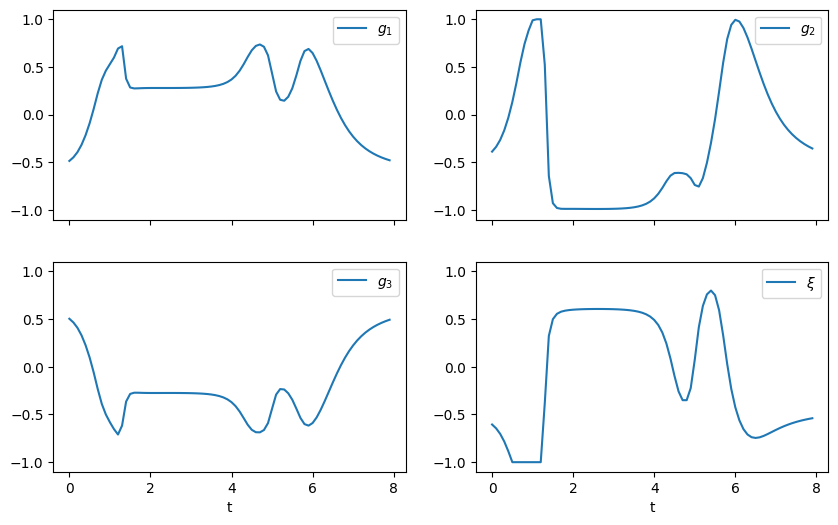

In [52]:
fig, ax = plt.subplots(2, 2, sharex=True)

fig.set_figwidth(10)
fig.set_figheight(6)

ax1 = ax[0, 0]
ax2 = ax[0, 1]
ax3 = ax[1, 0]
ax4 = ax[1, 1]


ax1.plot(time, g1, label = r"$g_1$")
ax2.plot(time, g2, label = r"$g_2$")
ax3.plot(time, g3, label = r"$g_3$")
ax4.plot(time, ξ, label = r"$\xi$")
ax1.set_ylim(-1.1, 1.1)
ax2.set_ylim(-1.1, 1.1)
ax3.set_ylim(-1.1, 1.1)
ax4.set_ylim(-1.1, 1.1)

ax4.set_xlabel("t")
ax3.set_xlabel("t")

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

In [53]:
fidelities = torch.tensor([fidelity(partial_trace(get_density_matrix(state), [3]), target_state) for state in states])

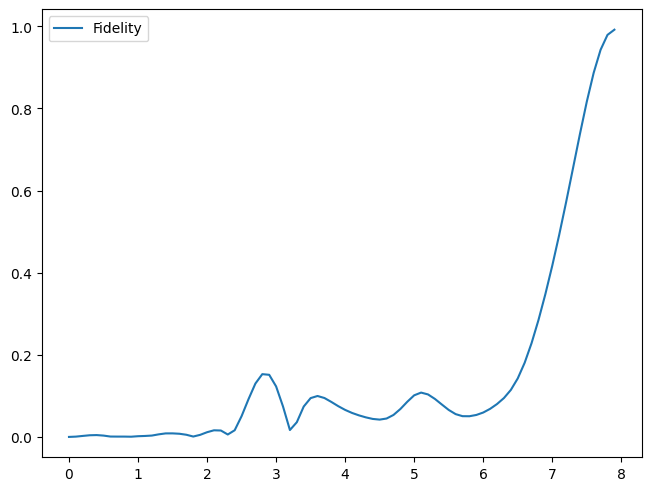

In [54]:
fig, ax = plt.subplots(layout='constrained')

ax.plot(time, fidelities, label=r"Fidelity")
ax.legend()